In [135]:
import sys
sys.path.append('../../..')

In [136]:
import numpy as np
from hyperbolicity.tree_fitting_methods.neighbor_joining import NJ
from hyperbolicity.tree_fitting_methods.treerep import TreeRep
from hyperbolicity.tree_fitting_methods.hccfit import HccLinkage
from hyperbolicity.tree_fitting_methods.gromov import gromov_tree, buneman_extraction
from hyperbolicity.delta import compute_hyperbolicity
from hyperbolicity.tree_fitting_methods.layering_tree import layering_approx_tree
from hyperbolicity.tree_fitting_methods.hdtree import hdtree
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import torch


plt.rcParams['text.usetex'] = True


import seaborn as sns
sns.set_theme(style="white")

In [137]:
from matplotlib.colors import Normalize

def draw_graph(n, distances, tree, ax, title='Tree', fixed_pos=None, fixed_nodes=None,
               node_size=500, edge_color='gray',root=0,show_root=True,
               orig_color = '#648FFF',
               int_color  = '#FE6100',
               root_color = '#DC267F',
               cmap=sns.color_palette("Blues", as_cmap=True),
               with_labels=True,
               scale_width=6,
               fs=24,
               vmin=0, vmax=2):

    orig_nodes_nj = [v for v in tree.nodes() if v < n]
    int_nodes_nj  = [v for v in tree.nodes() if v >= n]

    # Set edge weights from the distance matrix M
    edge_values = {}
    for (u, v) in tree.edges():
        tree[u][v]['weight_layout'] = 1./(.01+distances[u, v])
        edge_values[(u,v)]= distances[u, v]

    norm = Normalize(vmin=vmin, vmax=vmax)
    edge_colors = [cmap(norm(edge_values[edge])) for edge in tree.edges()]
    # Get positions for the nodes
    pos = nx.spring_layout(tree, pos=fixed_pos, fixed=fixed_nodes, weight='weight_layout',  iterations=1000)

    nx.draw_networkx_edges(tree, pos, ax=ax, edge_color=edge_colors, width=scale_width)
    #nx.draw_networkx_edges(tree, pos, ax=ax)
    nx.draw_networkx_nodes(tree, pos,
                        nodelist=orig_nodes_nj,
                        node_color=orig_color, node_size=node_size,
                        ax=ax)
    nx.draw_networkx_nodes(tree, pos,
                        nodelist=int_nodes_nj,
                        node_color=int_color,  node_size=node_size/2,
                        ax=ax)
    if show_root:
        nx.draw_networkx_nodes(tree, pos,
                        nodelist=[root] if root in tree else [],
                        node_color=root_color,
                        node_size=node_size*2, ax=ax)

    if with_labels:
        nx.draw_networkx_labels(tree, pos,
                                labels={v: str(v) for v in tree.nodes()},
                                font_size=12, font_color='black',
                                ax=ax)

    ax.set_title(title, pad=10,fontsize=fs)
    ax.axis('off')


def plot_distances(distances, ax, vmin=0, vmax=10,
                   cmap=sns.diverging_palette(230, 20, as_cmap=True)):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(distances, dtype=bool),k=1)

    # Draw the heatmap with the mask and correct aspect ratio
    #sns.heatmap(distances, mask=mask, cmap=cmap, vmin=vmin, vmax=vmax, center=0,
    #            square=True, linewidths=.5, cbar_kws={"shrink": .6},ax=ax)
    sns.heatmap(distances, mask=mask, cmap=cmap, vmin=vmin, vmax=vmax,
                square=True, linewidths=.5, cbar=False,ax=ax)

In [138]:
def create_sbm(n1=50, n2=50, p_in=0.3, p_out=0.05, seed=None):
    if seed is not None:
        np.random.seed(seed)
    sizes = [n1, n2]  # Community sizes
    prob_matrix = [[p_in, p_out], [p_out, p_in]]  # Block probability matrix
    G = nx.stochastic_block_model(sizes, prob_matrix, seed=seed)

    return G

from itertools import combinations, groupby
import random

def gnp_random_connected_graph(n, p):
    """
    Generates a random undirected graph, similarly to an Erdős-Rényi
    graph, but enforcing that the resulting graph is conneted
    """
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    return G

# generate graph and compute stuff

In [ ]:
root =2

N = 10
random_graph = nx.random_geometric_graph(N, 0.5,seed=11)
#N = 4*4
#random_graph = nx.grid_graph(dim=(4,4))
#random_graph = nx.convert_node_labels_to_integers(random_graph, first_label = 0)
#N1=20
#N2=20
#N = N1 + N2
#random_graph= create_sbm(n1=N1, n2=N2, p_in=0.5, p_out=0.005, seed=42)
#N=10
#random_graph = gnp_random_connected_graph(N,.1)

distances = nx.floyd_warshall_numpy(random_graph)

tree_nj = NJ(distances)
tree_nj_distances = nx.floyd_warshall_numpy(tree_nj)

tree_TR = TreeRep(distances)
tree_TR.learn_tree()
tree_TR_distances = nx.floyd_warshall_numpy(tree_TR.G)

tree_hcc = HccLinkage(distances)
tree_hcc.fit_tree(root)
tree_hcc_distance = nx.floyd_warshall_numpy(tree_hcc.G)

gromov_distance = gromov_tree(distances, root)
tree_gromov_full = buneman_extraction(gromov_distance, root)
distance_gromov_tree = nx.floyd_warshall_numpy(tree_gromov_full)

layering_tree = layering_approx_tree(random_graph, root)
distance_layering = nx.floyd_warshall_numpy(layering_tree)

opt_tree = hdtree(torch.tensor(distances), root, 1e-2, 1, N, 1000, .01, 2000, False, True)
opt_tree_full = buneman_extraction(opt_tree, root)
distance_hdtree = nx.floyd_warshall_numpy(opt_tree_full)


loss = 0.00956, delta = 0.00900, error = 0.05640:   4%|▍         | 89/2000 [00:00<00:09, 205.32it/s]

display

/var/folders/fj/02wx0ctd7vv0g1x6f6fb2j9m0000gn/T/ipykernel_44113/1236708427.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


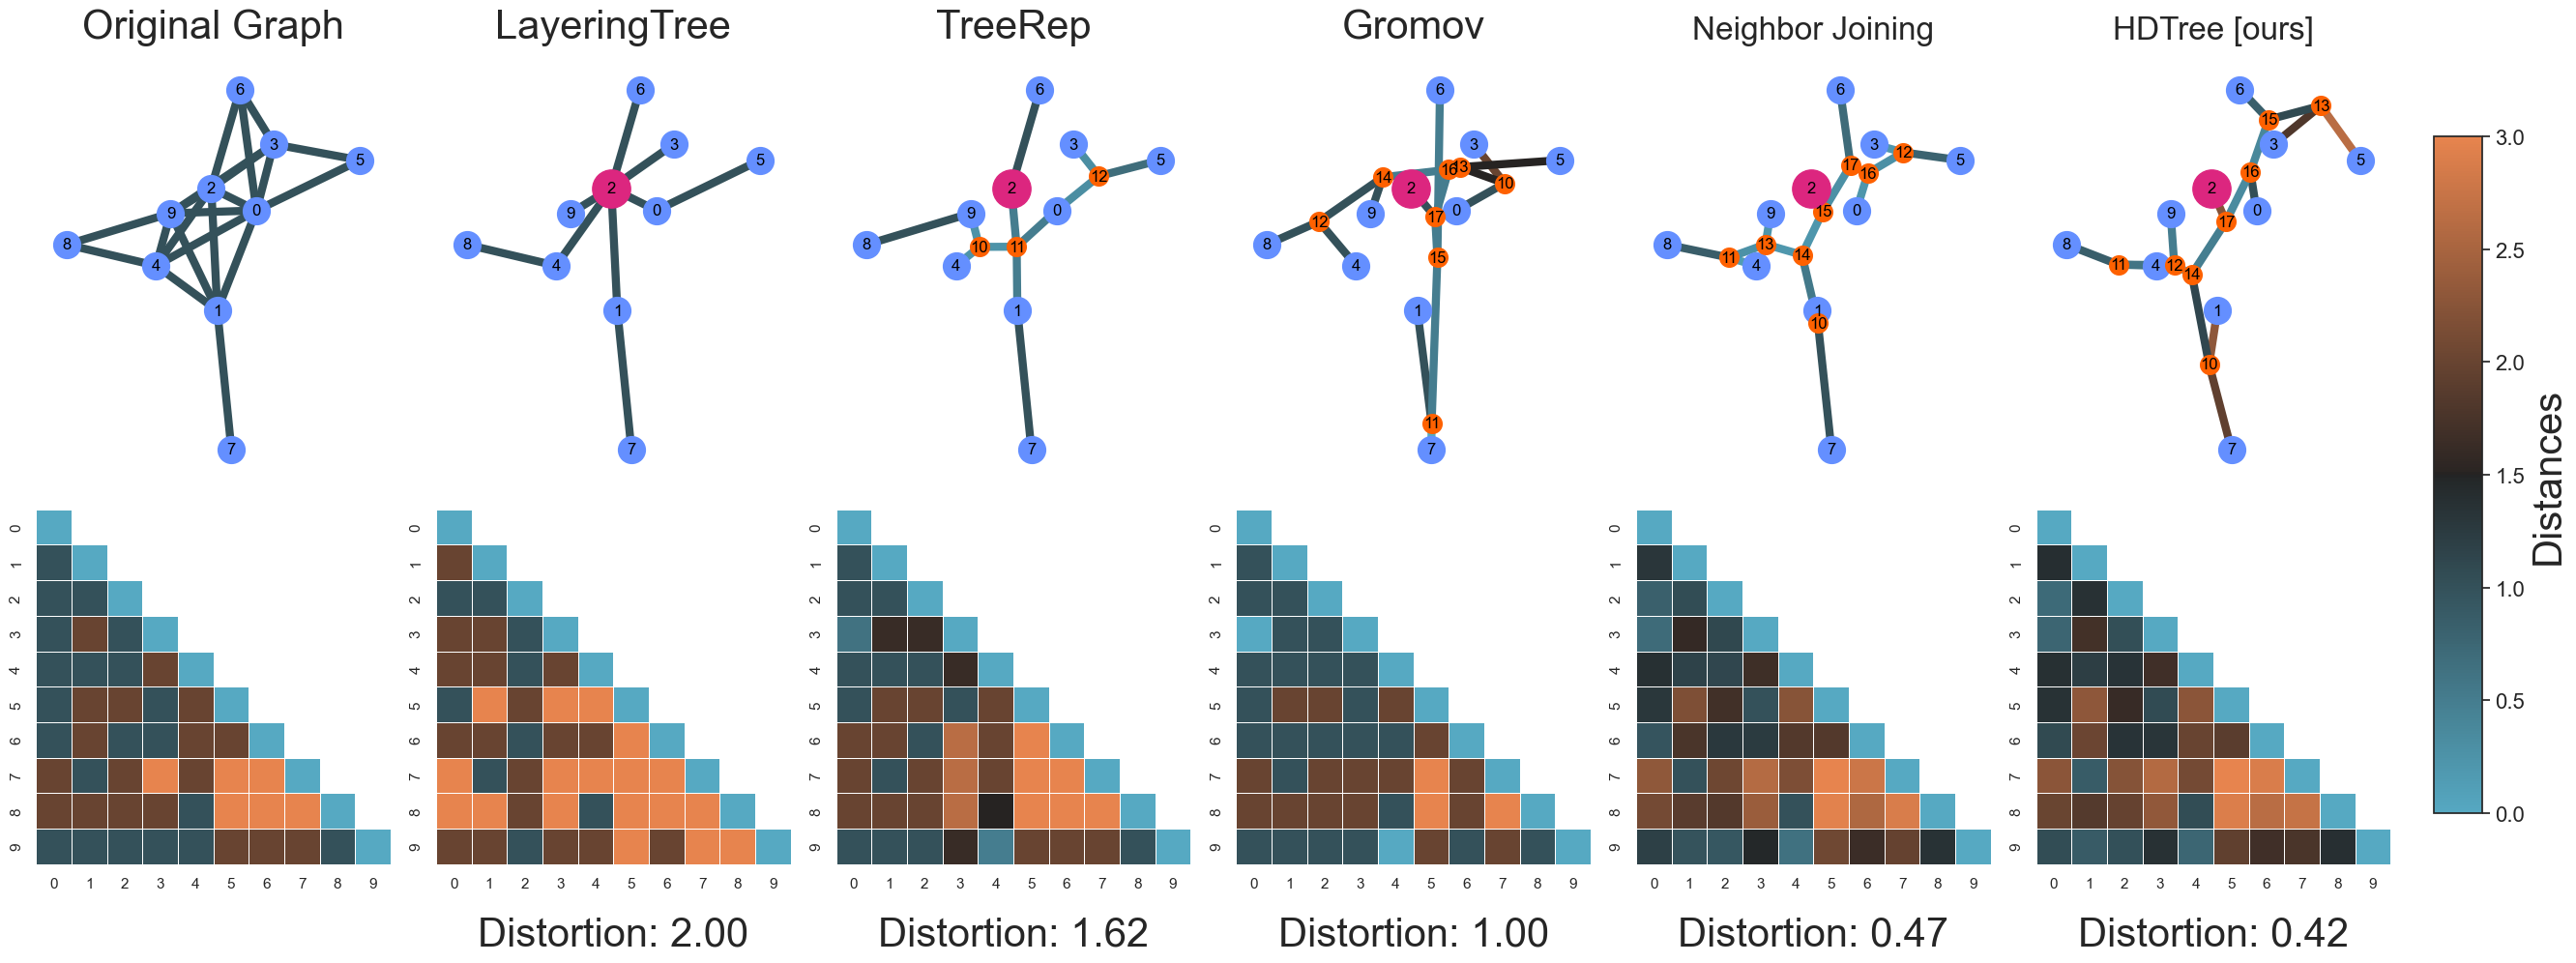

In [ ]:
node_size = 400
size_fig = 5
cmap_dist = sns.diverging_palette(220,30, l=65, center="dark", as_cmap=True)#sns.color_palette("icefire", as_cmap=True)
vmin = 0
vmax = 3
fs=30

# let's plot the trees
fig, axes = plt.subplots(2, 6, figsize=(5 * size_fig, 2 * size_fig))

# colorblind‑friendly
orig_color = '#648FFF'  # blue
int_color = '#FE6100'  # orange
root_color = '#DC267F'  # colorblind-friendly green

# 1) Original points with labels
ax = axes[0, 0]
fixed_positions = nx.spring_layout(random_graph, seed=0)
fixed_nodes = fixed_positions.keys()

draw_graph(N, distances, random_graph, ax, title='Original Graph', fixed_pos=fixed_positions, fixed_nodes=fixed_nodes,
           cmap=cmap_dist, node_size=node_size, show_root=False, vmax=vmax, fs=fs)

ax = axes[1, 0]
plot_distances(distances, ax, vmin=vmin, vmax=vmax, cmap=cmap_dist)

# 2) Chepoi
ax = axes[0, 1]
draw_graph(N, distance_layering, layering_tree, ax, title='LayeringTree', fixed_pos=fixed_positions, fixed_nodes=fixed_nodes,
           cmap=cmap_dist, node_size=node_size, root=root, vmax=vmax, fs=fs)
ax = axes[1, 1]
plot_distances(distance_layering[:N, :N], ax, vmin=vmin, vmax=vmax, cmap=cmap_dist)
distortion = np.abs(distances - distance_layering[:N, :N]).max()
ax.text(0.5, -0.2, f"Distortion: {distortion:.2f}", ha='center', va='center', transform=ax.transAxes, fontsize=fs)

# 3) TreeRep
ax = axes[0, 2]
draw_graph(N, tree_TR_distances, tree_TR.G, ax, title='TreeRep', fixed_pos=fixed_positions, fixed_nodes=fixed_nodes,
           cmap=cmap_dist, node_size=node_size, root=root, vmax=vmax, fs=fs)
ax = axes[1, 2]
plot_distances(tree_TR_distances[:N, :N], ax, vmin=vmin, vmax=vmax, cmap=cmap_dist)
distortion = np.abs(distances - tree_TR_distances[:N, :N]).max()
ax.text(0.5, -0.2, f"Distortion: {distortion:.2f}", ha='center', va='center', transform=ax.transAxes, fontsize=fs)

# 4) Gromov
ax = axes[0, 3]
draw_graph(N, distance_gromov_tree, tree_gromov_full, ax, title='Gromov', fixed_pos=fixed_positions, fixed_nodes=fixed_nodes,
           cmap=cmap_dist, node_size=node_size, root=root, vmax=vmax,fs=fs)
ax = axes[1, 3]
l = np.argsort(tree_gromov_full.nodes)
plot_distances(distance_gromov_tree[l][:N, l[:N]], ax, vmin=vmin, vmax=vmax, cmap=cmap_dist)
distortion = np.abs(distances - distance_gromov_tree[l][:N, l[:N]]).max()
ax.text(0.5, -0.2, f"Distortion: {distortion:.2f}", ha='center', va='center', transform=ax.transAxes, fontsize=fs)



# 5) Neighbor‑Joining
ax = axes[0, 4]
draw_graph(N, tree_nj_distances, tree_nj, ax, title='Neighbor Joining', fixed_pos=fixed_positions, fixed_nodes=fixed_nodes,
           cmap=cmap_dist, node_size=node_size, root=root, vmax=vmax)
ax = axes[1, 4]
plot_distances(tree_nj_distances[:N, :N], ax, vmin=vmin, vmax=vmax, cmap=cmap_dist)
distortion = np.abs(distances - tree_nj_distances[:N, :N]).max()
ax.text(0.5, -0.2, f"Distortion: {distortion:.2f}", ha='center', va='center', transform=ax.transAxes, fontsize=fs)




# 7) HDTree
ax = axes[0, 5]
draw_graph(N, distance_hdtree, opt_tree_full, ax, title='HDTree [ours]', fixed_pos=fixed_positions, fixed_nodes=fixed_nodes,
           cmap=cmap_dist, node_size=node_size, root=root, vmax=vmax)
l = np.argsort(opt_tree_full.nodes)
ax = axes[1, 5]
plot_distances(distance_hdtree[l][:N, l[:N]], ax, vmin=vmin, vmax=vmax, cmap=cmap_dist)
distortion = np.abs(distances - distance_hdtree[l][:N, l[:N]]).max()
ax.text(0.5, -0.2, f"Distortion: {distortion:.2f}", ha='center', va='center', transform=ax.transAxes, fontsize=fs)

cbar_ax = fig.add_axes([1.01, 0.15, 0.02, 0.7])  # Position: [gauche, bas, largeur, hauteur]
sm = plt.cm.ScalarMappable(cmap=cmap_dist, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Distances', fontsize=fs)
cbar.ax.tick_params(labelsize=16)

plt.tight_layout()
plt.show()